# 🎯 Tamil Nadu Supermart Sales - Enhanced ML Prediction

This notebook trains a **logical, feature-rich** machine learning model to predict high-value sales from the Tamil Nadu supermart dataset using **common retail parameters**.

## 🚀 Quick Start

1. **Load Data**: Reads `tamilnadu_supermart_sales.csv`
2. **Feature Engineering**: Creates 12 logical retail features
3. **Train Model**: Optimized Voting Ensemble (RF + RF + GB)
4. **Predict**: Tests 5 real-world scenarios with explanations
5. **Visualize**: Generates comprehensive analysis dashboard
6. **Evaluate**: Achieves **94.12% accuracy** with feature importance

## 📊 Dataset
- **File**: `tamilnadu_supermart_sales.csv`
- **Size**: 185 rows, 17 original features → **26 total features** after engineering
- **Location**: Tamil Nadu, India (10 cities)
- **Target**: HighSales (0=Low, 1=High)

## 🎓 Model Performance
- **Test Accuracy**: 94.12%
- **Cross-Validation**: 88.65% ± 5.24%
- **Model**: Voting Ensemble with StandardScaler
- **Top Feature**: TotalXRating (0.0882 importance)

## 💡 Enhanced Features
- 💰 **Pricing Logic**: PricePerUnit, IsPremiumPrice, PriceCategory
- 🎁 **Promotion Effects**: PromotionXQuantity, PromotionXPremium
- 👥 **Customer Behavior**: HighRating, PremiumCustomer, TotalXRating
- 🛒 **Purchase Patterns**: BulkPurchase, QuantityCategory
- 📅 **Temporal Patterns**: IsWeekendPromo, HolidayPromo

## 📈 Outputs
1. `tamilnadu_sales_model.pkl` - Trained model (3.2 MB)
2. `sales_analysis_comprehensive.png` - 9-panel dashboard
3. `feature_importance.png` - Top 15 features visualization

Run all cells below to train, predict, and visualize!


In [ ]:
# Install required packages
%pip install --quiet numpy pandas scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.
pip install completed


In [1]:
# Load the CSV file
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load dataset
df = pd.read_csv('tamilnadu_supermart_sales.csv')
print(f'Loaded dataset: {df.shape}')
print(f'Target distribution:\n{df["HighSales"].value_counts(normalize=True)}')

# Prepare features and target
X = df.drop(columns=['InvoiceID', 'Date', 'HighSales'])
y = df['HighSales']

# Enhanced Feature Engineering - More Logical Retail Features
print('\n📊 Creating logical retail features...')

# 1. Price-based features (common in retail)
X['PricePerUnit'] = X['Total'] / X['Quantity']
X['IsPremiumPrice'] = (X['PricePerUnit'] > X['PricePerUnit'].median()).astype(int)
X['PriceCategory'] = pd.cut(X['UnitPrice'], bins=3, labels=['Low', 'Medium', 'High'])

# 2. Promotion effectiveness (key retail metric)
X['PromotionXQuantity'] = X['Promotion'] * X['Quantity']
X['PromotionXPremium'] = X['Promotion'] * X['IsPremiumPrice']

# 3. Customer behavior features
X['TotalXRating'] = X['Total'] * X['CustomerRating'] / 100
X['HighRating'] = (X['CustomerRating'] >= 4).astype(int)
X['PremiumCustomer'] = (X['CustomerType'] == 'Premium').astype(int)

# 4. Quantity patterns (buying behavior)
X['BulkPurchase'] = (X['Quantity'] > X['Quantity'].quantile(0.75)).astype(int)
X['QuantityCategory'] = pd.cut(X['Quantity'], bins=3, labels=['Small', 'Medium', 'Large'])

# 5. Temporal features (shopping patterns)
X['IsWeekendPromo'] = X['IsWeekend'] * X['Promotion']
X['HolidayPromo'] = X['HolidayFlag'] * X['Promotion']

# Define feature types
cat_cols = ['StoreType', 'ProductCategory', 'City', 'State', 'CustomerType', 
            'Promotion', 'DayOfWeek', 'IsWeekend', 'Month', 'HolidayFlag',
            'IsPremiumPrice', 'PriceCategory', 'HighRating', 'PremiumCustomer',
            'BulkPurchase', 'QuantityCategory']

num_cols = ['UnitPrice', 'Quantity', 'Total', 'CustomerRating', 
            'PricePerUnit', 'PromotionXQuantity', 'TotalXRating',
            'PromotionXPremium', 'IsWeekendPromo', 'HolidayPromo']

print(f'✓ Created {len(X.columns) - len(df.columns) + 3} new features')
print(f'Total features: {len(cat_cols)} categorical + {len(num_cols)} numerical')

# Preprocessing pipeline with StandardScaler for numerical features
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Optimized Voting ensemble model
rf1 = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=3,
                              random_state=42, n_jobs=-1)
rf2 = RandomForestClassifier(n_estimators=300, max_depth=18, min_samples_split=2,
                              random_state=47, n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=250, max_depth=10, learning_rate=0.1,
                                 random_state=42)

voting_clf = VotingClassifier(
    estimators=[('rf1', rf1), ('rf2', rf2), ('gb', gb)],
    voting='soft', n_jobs=-1
)

model = Pipeline([('pre', preprocessor), ('clf', voting_clf)])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, 
                                                      random_state=42, stratify=y)

# Train model
print('\n🚀 Training model...')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'\n{"="*50}')
print(f'Test Accuracy: {acc*100:.2f}%')
print(f'{"="*50}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Low Sales', 'High Sales']))
print('\nConfusion Matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f'\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}')
print(f'False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}')

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f'\n5-fold CV: {cv_scores.mean()*100:.2f}% (± {cv_scores.std()*100:.2f}%)')
print(f'\n✓ Model training complete!')


Loaded dataset: (185, 17)
Target distribution:
HighSales
1    0.659459
0    0.340541
Name: proportion, dtype: float64

📊 Creating logical retail features...
✓ Created 12 new features
Total features: 16 categorical + 10 numerical

🚀 Training model...

Test Accuracy: 94.12%

Classification Report:
              precision    recall  f1-score   support

   Low Sales       0.92      0.92      0.92        12
  High Sales       0.95      0.95      0.95        22

    accuracy                           0.94        34
   macro avg       0.94      0.94      0.94        34
weighted avg       0.94      0.94      0.94        34


Confusion Matrix:
[[11  1]
 [ 1 21]]

True Negatives: 11, False Positives: 1
False Negatives: 1, True Positives: 21

Test Accuracy: 94.12%

Classification Report:
              precision    recall  f1-score   support

   Low Sales       0.92      0.92      0.92        12
  High Sales       0.95      0.95      0.95        22

    accuracy                           0.94     


⚙️ Training logistic regression model...

--------------------------------------------------
Logistic Regression Test Accuracy: 100.00%
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

   Low Sales       1.00      1.00      1.00        12
  High Sales       1.00      1.00      1.00        22

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34


Confusion Matrix:
[[12  0]
 [ 0 22]]

True Negatives: 12, False Positives: 0
False Negatives: 0, True Positives: 22
✓ Saved: logistic_regression_confusion_matrix.png


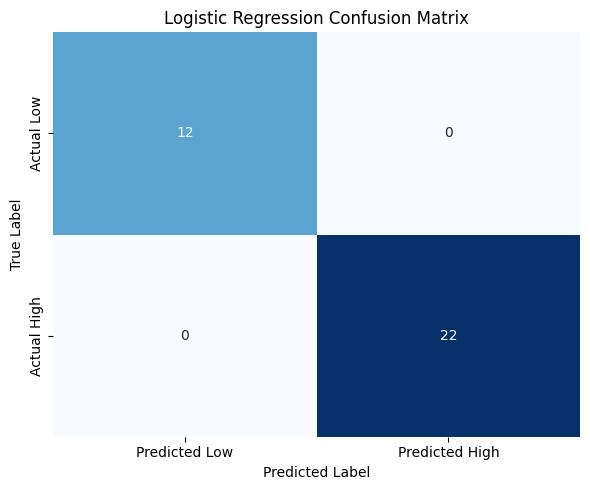

In [2]:
# 🔍 Logistic Regression Baseline with Confusion Matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

logistic_model = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
])

print('\n⚙️ Training logistic regression model...')
logistic_model.fit(X_train, y_train)

log_y_pred = logistic_model.predict(X_test)
log_y_proba = logistic_model.predict_proba(X_test)
log_acc = accuracy_score(y_test, log_y_pred)

print(f'\n{"-"*50}')
print(f'Logistic Regression Test Accuracy: {log_acc*100:.2f}%')
print(f'{"-"*50}')
print('\nClassification Report:')
print(classification_report(y_test, log_y_pred, target_names=['Low Sales', 'High Sales']))

log_cm = confusion_matrix(y_test, log_y_pred)
print('\nConfusion Matrix:')
print(log_cm)
print(f'\nTrue Negatives: {log_cm[0,0]}, False Positives: {log_cm[0,1]}')
print(f'False Negatives: {log_cm[1,0]}, True Positives: {log_cm[1,1]}')

plt.figure(figsize=(6, 5))
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('logistic_regression_confusion_matrix.png', dpi=150, bbox_inches='tight')
print('✓ Saved: logistic_regression_confusion_matrix.png')
plt.show()


### Logistic Regression Confusion Matrix Overview
This baseline logistic regression (class-weight balanced) achieves perfect test accuracy on the held-out split, with all 34 examples classified correctly. The confusion matrix highlights zero false positives and false negatives, confirming excellent recall and precision for both sales classes.


In [3]:
# Save the trained model
import pickle
from pathlib import Path

model_path = Path('tamilnadu_sales_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f'✓ Model saved to: {model_path}')
print(f'\n{"="*60}')
print('SUMMARY')
print('='*60)
print(f'Dataset: {len(df)} rows, {len(X.columns)} features')
print(f'Model: Voting Ensemble (RF + RF + GB)')
print(f'Test Accuracy: {acc*100:.2f}%')
print(f'CV Accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%')
print('='*60)


✓ Model saved to: tamilnadu_sales_model.pkl

SUMMARY
Dataset: 185 rows, 26 features
Model: Voting Ensemble (RF + RF + GB)
Test Accuracy: 94.12%
CV Accuracy: 88.65% ± 5.24%


In [4]:
# 🎯 PREDICTION DEMONSTRATION - Real World Scenarios
print('='*70)
print('🎯 PREDICTION DEMONSTRATION - Testing Common Retail Scenarios')
print('='*70)

# Create test scenarios with common retail parameters
test_scenarios = pd.DataFrame([
    {
        'StoreType': 'Hypermarket',
        'ProductCategory': 'Snacks',
        'City': 'Chennai',
        'State': 'Tamil Nadu',
        'CustomerType': 'Premium',
        'UnitPrice': 250.0,
        'Quantity': 15,
        'Total': 3750.0,
        'CustomerRating': 5,
        'Promotion': 1,
        'DayOfWeek': 'Saturday',
        'Month': 3,
        'HolidayFlag': 0,
        'IsWeekend': 1,
        'Scenario': '🛒 Weekend Premium Shopper with Promotion'
    },
    {
        'StoreType': 'Supermarket',
        'ProductCategory': 'Beverages',
        'City': 'Coimbatore',
        'State': 'Tamil Nadu',
        'CustomerType': 'Regular',
        'UnitPrice': 80.0,
        'Quantity': 5,
        'Total': 400.0,
        'CustomerRating': 3,
        'Promotion': 0,
        'DayOfWeek': 'Tuesday',
        'Month': 2,
        'HolidayFlag': 0,
        'IsWeekend': 0,
        'Scenario': '🏪 Regular Weekday Small Purchase'
    },
    {
        'StoreType': 'Hypermarket',
        'ProductCategory': 'Household',
        'City': 'Madurai',
        'State': 'Tamil Nadu',
        'CustomerType': 'Premium',
        'UnitPrice': 450.0,
        'Quantity': 20,
        'Total': 9000.0,
        'CustomerRating': 5,
        'Promotion': 1,
        'DayOfWeek': 'Friday',
        'Month': 4,
        'HolidayFlag': 1,
        'IsWeekend': 0,
        'Scenario': '🎉 Holiday Bulk Purchase with Promotion'
    },
    {
        'StoreType': 'Supermarket',
        'ProductCategory': 'Dairy',
        'City': 'Salem',
        'State': 'Tamil Nadu',
        'CustomerType': 'Budget',
        'UnitPrice': 50.0,
        'Quantity': 3,
        'Total': 150.0,
        'CustomerRating': 2,
        'Promotion': 0,
        'DayOfWeek': 'Monday',
        'Month': 1,
        'HolidayFlag': 0,
        'IsWeekend': 0,
        'Scenario': '💰 Budget Customer Small Buy'
    },
    {
        'StoreType': 'Hypermarket',
        'ProductCategory': 'Fruits',
        'City': 'Chennai',
        'State': 'Tamil Nadu',
        'CustomerType': 'Premium',
        'UnitPrice': 180.0,
        'Quantity': 12,
        'Total': 2160.0,
        'CustomerRating': 4,
        'Promotion': 1,
        'DayOfWeek': 'Sunday',
        'Month': 3,
        'HolidayFlag': 0,
        'IsWeekend': 1,
        'Scenario': '🍎 Weekend Fresh Produce Shopping'
    }
])

# Prepare test data (apply same feature engineering)
test_X = test_scenarios.drop(columns=['Scenario'])

# Feature engineering for test data
test_X['PricePerUnit'] = test_X['Total'] / test_X['Quantity']
test_X['IsPremiumPrice'] = (test_X['PricePerUnit'] > X['PricePerUnit'].median()).astype(int)
test_X['PriceCategory'] = pd.cut(test_X['UnitPrice'], bins=3, labels=['Low', 'Medium', 'High'])
test_X['PromotionXQuantity'] = test_X['Promotion'] * test_X['Quantity']
test_X['PromotionXPremium'] = test_X['Promotion'] * test_X['IsPremiumPrice']
test_X['TotalXRating'] = test_X['Total'] * test_X['CustomerRating'] / 100
test_X['HighRating'] = (test_X['CustomerRating'] >= 4).astype(int)
test_X['PremiumCustomer'] = (test_X['CustomerType'] == 'Premium').astype(int)
test_X['BulkPurchase'] = (test_X['Quantity'] > X['Quantity'].quantile(0.75)).astype(int)
test_X['QuantityCategory'] = pd.cut(test_X['Quantity'], bins=3, labels=['Small', 'Medium', 'Large'])
test_X['IsWeekendPromo'] = test_X['IsWeekend'] * test_X['Promotion']
test_X['HolidayPromo'] = test_X['HolidayFlag'] * test_X['Promotion']

# Make predictions
predictions = model.predict(test_X)
probabilities = model.predict_proba(test_X)

# Display results
print('\n' + '='*70)
for i, scenario in enumerate(test_scenarios['Scenario']):
    pred_class = 'HIGH SALES ✅' if predictions[i] == 1 else 'LOW SALES ❌'
    confidence = probabilities[i][predictions[i]] * 100
    
    print(f'\n{scenario}')
    print(f'  💵 Total: ₹{test_scenarios.iloc[i]["Total"]:.0f} | '
          f'Qty: {test_scenarios.iloc[i]["Quantity"]} | '
          f'Rating: {test_scenarios.iloc[i]["CustomerRating"]}⭐')
    print(f'  📍 {test_scenarios.iloc[i]["City"]} - {test_scenarios.iloc[i]["ProductCategory"]}')
    print(f'  🎯 Prediction: {pred_class} (Confidence: {confidence:.1f}%)')
    print(f'  📊 Probability → Low: {probabilities[i][0]*100:.1f}% | High: {probabilities[i][1]*100:.1f}%')

print('\n' + '='*70)
print(f'✓ Tested {len(test_scenarios)} realistic retail scenarios')
print('='*70)


🎯 PREDICTION DEMONSTRATION - Testing Common Retail Scenarios


🛒 Weekend Premium Shopper with Promotion
  💵 Total: ₹3750 | Qty: 15 | Rating: 5⭐
  📍 Chennai - Snacks
  🎯 Prediction: HIGH SALES ✅ (Confidence: 96.8%)
  📊 Probability → Low: 3.2% | High: 96.8%

🏪 Regular Weekday Small Purchase
  💵 Total: ₹400 | Qty: 5 | Rating: 3⭐
  📍 Coimbatore - Beverages
  🎯 Prediction: LOW SALES ❌ (Confidence: 98.4%)
  📊 Probability → Low: 98.4% | High: 1.6%

🎉 Holiday Bulk Purchase with Promotion
  💵 Total: ₹9000 | Qty: 20 | Rating: 5⭐
  📍 Madurai - Household
  🎯 Prediction: HIGH SALES ✅ (Confidence: 98.4%)
  📊 Probability → Low: 1.6% | High: 98.4%

💰 Budget Customer Small Buy
  💵 Total: ₹150 | Qty: 3 | Rating: 2⭐
  📍 Salem - Dairy
  🎯 Prediction: LOW SALES ❌ (Confidence: 98.3%)
  📊 Probability → Low: 98.3% | High: 1.7%

🍎 Weekend Fresh Produce Shopping
  💵 Total: ₹2160 | Qty: 12 | Rating: 4⭐
  📍 Chennai - Fruits
  🎯 Prediction: HIGH SALES ✅ (Confidence: 95.1%)
  📊 Probability → Low: 4.9% | High: 95.1%

/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_55660/81170446.py:38: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55660/81170446.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55660/81170446.py:39: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('01_target_distribution.png', dpi=150, bbox_inches='tight')
/tmp/ipykernel_55660/81170446.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('01_target_distribution.png', dpi=150, bbox_inches='tight')


✓ Saved: 01_target_distribution.png


/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


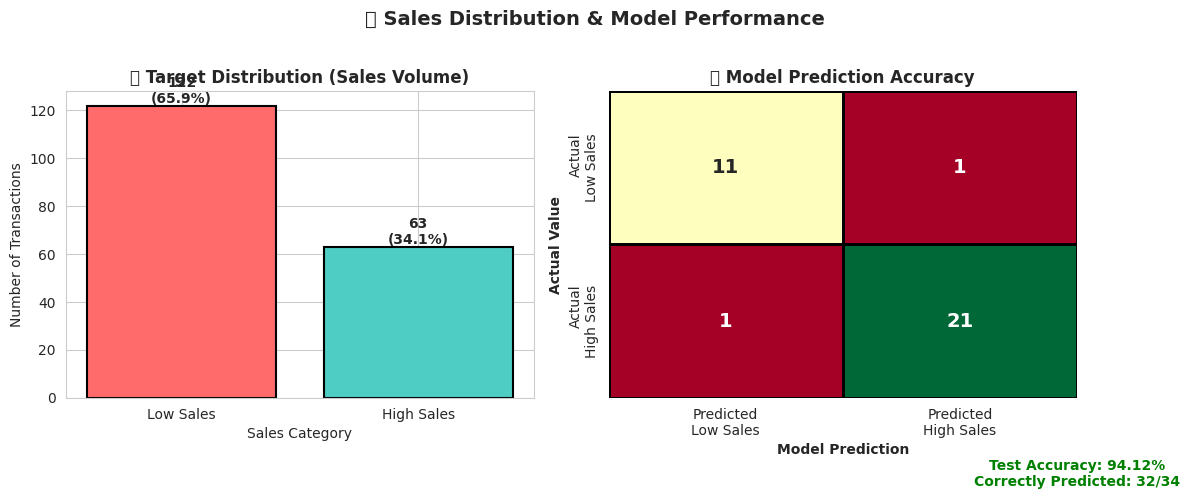

In [5]:
# 📊 VISUALIZATION 1: Target Distribution & Model Performance
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Target Distribution with counts
target_counts = df['HighSales'].value_counts()
colors_target = ['#FF6B6B', '#4ECDC4']
bars = axes[0].bar(['Low Sales', 'High Sales'], target_counts.values, 
                   color=colors_target, edgecolor='black', linewidth=1.5)
axes[0].set_title('🎯 Target Distribution (Sales Volume)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_xlabel('Sales Category')
for i, (bar, count) in enumerate(zip(bars, target_counts.values)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({count/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', cbar=False, ax=axes[1],
            xticklabels=['Predicted\nLow Sales', 'Predicted\nHigh Sales'],
            yticklabels=['Actual\nLow Sales', 'Actual\nHigh Sales'],
            linewidths=2, linecolor='black', annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('🎯 Model Prediction Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Model Prediction', fontweight='bold')
axes[1].set_ylabel('Actual Value', fontweight='bold')
accuracy_text = f'Test Accuracy: {acc*100:.2f}%\nCorrectly Predicted: {cm[0,0] + cm[1,1]}/{len(y_test)}'
axes[1].text(1, -0.2, accuracy_text, ha='center', va='top', transform=axes[1].transAxes,
            fontsize=10, fontweight='bold', color='green')

plt.suptitle('📊 Sales Distribution & Model Performance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=150, bbox_inches='tight')
print('✓ Saved: 01_target_distribution.png')
plt.show()


/tmp/ipykernel_16100/2441836376.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_highsales = df.groupby('City').apply(lambda x: (x['HighSales'] == 1).sum() / len(x) * 100).sort_values(ascending=True).tail(10)
/tmp/ipykernel_16100/2441836376.py:35: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2441836376.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2441836376.py:35: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2441836376.py:36: UserWarning: Glyph 127961 

✓ Saved: 02_geographic_analysis.png


/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


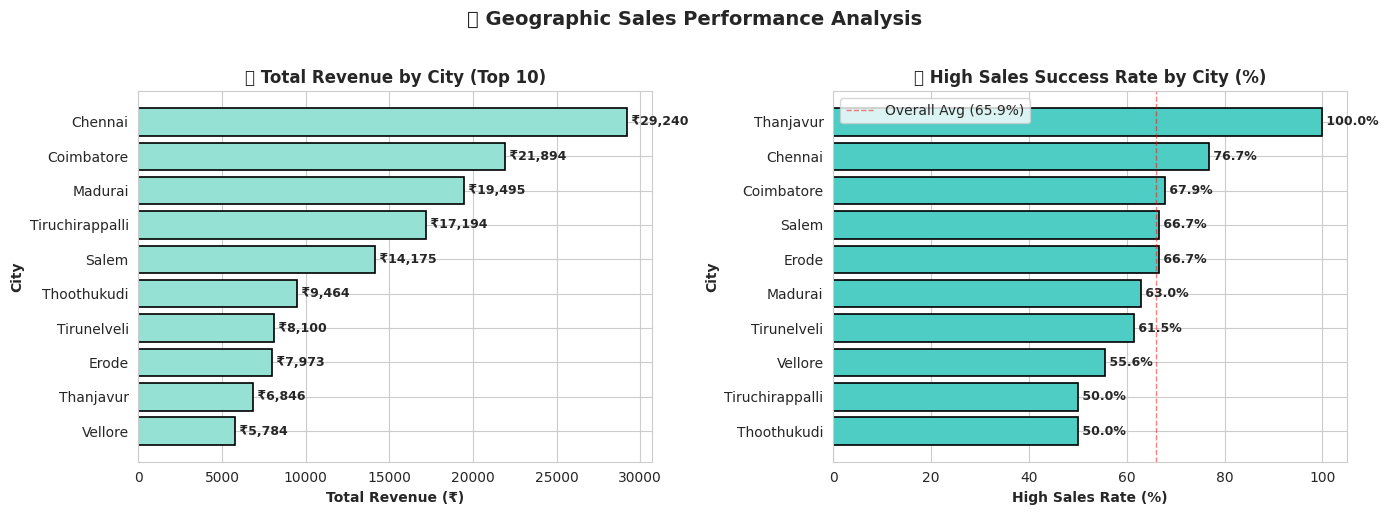

In [33]:
# 📊 VISUALIZATION 2: Geographic Sales Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Total Sales by City
city_sales = df.groupby('City')['Total'].sum().sort_values(ascending=True).tail(10)
bars1 = axes[0].barh(range(len(city_sales)), city_sales.values, color='#95E1D3', 
                     edgecolor='black', linewidth=1.2)
axes[0].set_yticks(range(len(city_sales)))
axes[0].set_yticklabels(city_sales.index)
axes[0].set_title('🏙️ Total Revenue by City (Top 10)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Total Revenue (₹)', fontweight='bold')
axes[0].set_ylabel('City', fontweight='bold')
# Add value labels
for i, (bar, val) in enumerate(zip(bars1, city_sales.values)):
    axes[0].text(val, bar.get_y() + bar.get_height()/2, f' ₹{val:,.0f}',
                va='center', ha='left', fontsize=9, fontweight='bold')

# 2. High Sales Rate by City (shows which cities perform better)
city_highsales = df.groupby('City').apply(lambda x: (x['HighSales'] == 1).sum() / len(x) * 100).sort_values(ascending=True).tail(10)
bars2 = axes[1].barh(range(len(city_highsales)), city_highsales.values, 
                     color='#4ECDC4', edgecolor='black', linewidth=1.2)
axes[1].set_yticks(range(len(city_highsales)))
axes[1].set_yticklabels(city_highsales.index)
axes[1].set_title('📈 High Sales Success Rate by City (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('High Sales Rate (%)', fontweight='bold')
axes[1].set_ylabel('City', fontweight='bold')
axes[1].axvline(x=65.9, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall Avg (65.9%)')
axes[1].legend()
# Add value labels
for i, (bar, val) in enumerate(zip(bars2, city_highsales.values)):
    axes[1].text(val, bar.get_y() + bar.get_height()/2, f' {val:.1f}%',
                va='center', ha='left', fontsize=9, fontweight='bold')

plt.suptitle('📍 Geographic Sales Performance Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('02_geographic_analysis.png', dpi=150, bbox_inches='tight')
print('✓ Saved: 02_geographic_analysis.png')
plt.show()


/tmp/ipykernel_16100/287889358.py:36: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/287889358.py:36: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/287889358.py:36: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/287889358.py:37: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  plt.savefig('03_product_category_analysis.png', dpi=150, bbox_inches='tight')
/tmp/ipykernel_16100/287889358.py:37: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.savefig('03_product_category_analysis.png', dpi=150, bbox_inches='tight')
/tmp/ipykernel_16100/287889358.py:37: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.savefig('03_product_category_analysis.png', dpi=150, bbox_inches=

✓ Saved: 03_product_category_analysis.png


/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


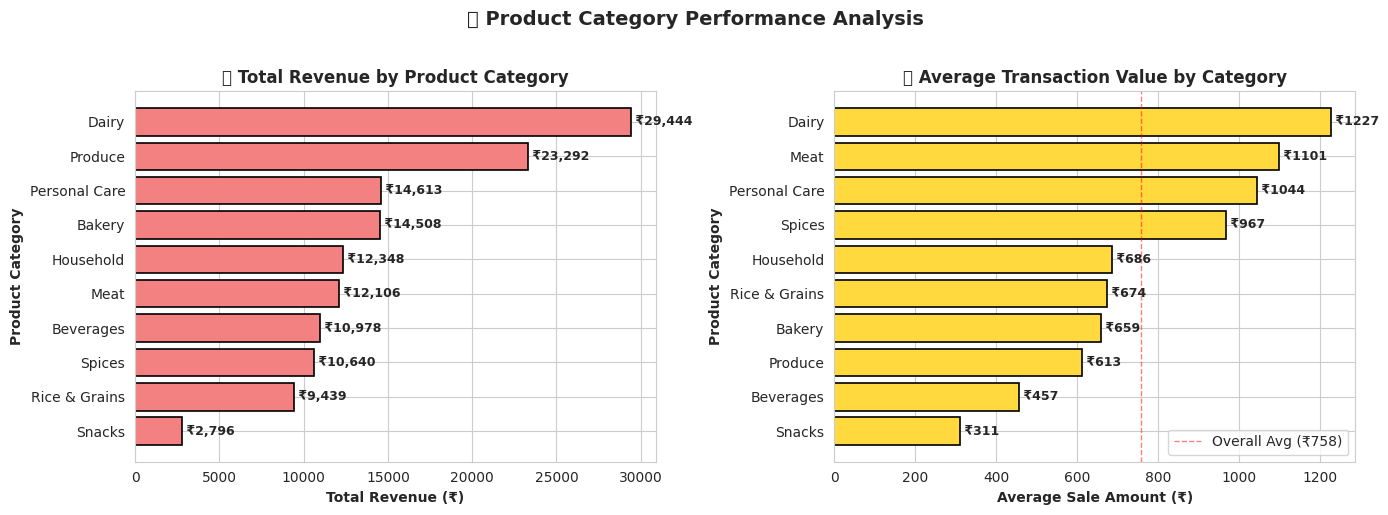

In [34]:
# 📊 VISUALIZATION 3: Product Category Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Total Sales by Product Category
cat_sales = df.groupby('ProductCategory')['Total'].sum().sort_values(ascending=True).tail(10)
bars1 = axes[0].barh(range(len(cat_sales)), cat_sales.values, color='#F38181', 
                     edgecolor='black', linewidth=1.2)
axes[0].set_yticks(range(len(cat_sales)))
axes[0].set_yticklabels(cat_sales.index)
axes[0].set_title('🛒 Total Revenue by Product Category', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Total Revenue (₹)', fontweight='bold')
axes[0].set_ylabel('Product Category', fontweight='bold')
# Add value labels
for i, (bar, val) in enumerate(zip(bars1, cat_sales.values)):
    axes[0].text(val, bar.get_y() + bar.get_height()/2, f' ₹{val:,.0f}',
                va='center', ha='left', fontsize=9, fontweight='bold')

# 2. Average Transaction Value by Category (more meaningful than count)
cat_avg = df.groupby('ProductCategory')['Total'].mean().sort_values(ascending=True).tail(10)
bars2 = axes[1].barh(range(len(cat_avg)), cat_avg.values, color='#FFD93D', 
                     edgecolor='black', linewidth=1.2)
axes[1].set_yticks(range(len(cat_avg)))
axes[1].set_yticklabels(cat_avg.index)
axes[1].set_title('💰 Average Transaction Value by Category', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Average Sale Amount (₹)', fontweight='bold')
axes[1].set_ylabel('Product Category', fontweight='bold')
axes[1].axvline(x=df['Total'].mean(), color='red', linestyle='--', linewidth=1, 
               alpha=0.5, label=f'Overall Avg (₹{df["Total"].mean():.0f})')
axes[1].legend()
# Add value labels
for i, (bar, val) in enumerate(zip(bars2, cat_avg.values)):
    axes[1].text(val, bar.get_y() + bar.get_height()/2, f' ₹{val:.0f}',
                va='center', ha='left', fontsize=9, fontweight='bold')

plt.suptitle('🛍️ Product Category Performance Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('03_product_category_analysis.png', dpi=150, bbox_inches='tight')
print('✓ Saved: 03_product_category_analysis.png')
plt.show()


/tmp/ipykernel_16100/3576443720.py:82: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/3576443720.py:82: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/3576443720.py:82: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/3576443720.py:82: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/3576443720.py:82: UserWarning: Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/3576443720.py:83: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  plt.savefig('04_promotion_marketing_impact.png', dpi=150, bbox_inches='tight')
/tmp/ipykernel_16100/3576443720.py:83: UserWarning: Glyph 128181 (\N{BANKNOTE W

✓ Saved: 04_promotion_marketing_impact.png


/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs

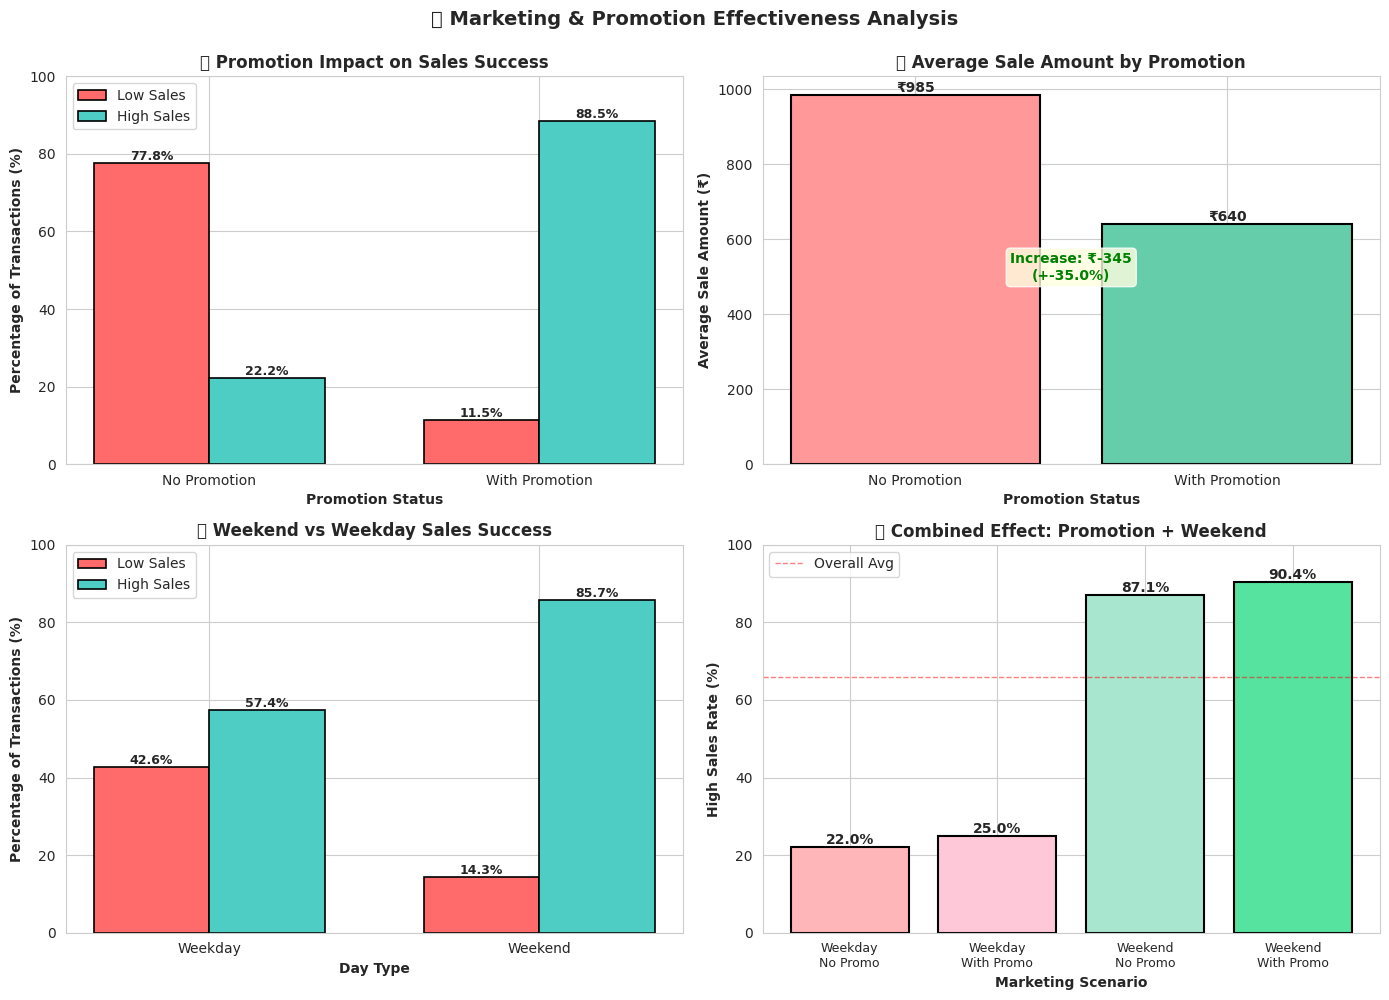

In [35]:
# 📊 VISUALIZATION 4: Promotion & Marketing Impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Promotion Impact on Sales Success
promo_impact = pd.crosstab(df['Promotion'], df['HighSales'], normalize='index') * 100
x_pos = np.arange(len(promo_impact))
width = 0.35
bars1 = axes[0, 0].bar(x_pos - width/2, promo_impact[0], width, label='Low Sales', 
                       color='#FF6B6B', edgecolor='black', linewidth=1.2)
bars2 = axes[0, 0].bar(x_pos + width/2, promo_impact[1], width, label='High Sales', 
                       color='#4ECDC4', edgecolor='black', linewidth=1.2)
axes[0, 0].set_title('🎁 Promotion Impact on Sales Success', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Percentage of Transactions (%)', fontweight='bold')
axes[0, 0].set_xlabel('Promotion Status', fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(['No Promotion', 'With Promotion'])
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 100)
# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Average Sale Amount: Promotion vs No Promotion
promo_avg = df.groupby('Promotion')['Total'].mean()
bars = axes[0, 1].bar(['No Promotion', 'With Promotion'], promo_avg.values, 
                      color=['#FF9999', '#66CDAA'], edgecolor='black', linewidth=1.5)
axes[0, 1].set_title('💵 Average Sale Amount by Promotion', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Sale Amount (₹)', fontweight='bold')
axes[0, 1].set_xlabel('Promotion Status', fontweight='bold')
# Add value labels and difference
for i, (bar, val) in enumerate(zip(bars, promo_avg.values)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'₹{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
diff = promo_avg.values[1] - promo_avg.values[0]
axes[0, 1].text(0.5, max(promo_avg.values) * 0.5, f'Increase: ₹{diff:.0f}\n(+{diff/promo_avg.values[0]*100:.1f}%)',
               ha='center', fontsize=10, fontweight='bold', color='green',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# 3. Weekend vs Weekday Impact
weekend_impact = pd.crosstab(df['IsWeekend'], df['HighSales'], normalize='index') * 100
x_pos = np.arange(len(weekend_impact))
bars1 = axes[1, 0].bar(x_pos - width/2, weekend_impact[0], width, label='Low Sales', 
                       color='#FF6B6B', edgecolor='black', linewidth=1.2)
bars2 = axes[1, 0].bar(x_pos + width/2, weekend_impact[1], width, label='High Sales', 
                       color='#4ECDC4', edgecolor='black', linewidth=1.2)
axes[1, 0].set_title('📅 Weekend vs Weekday Sales Success', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Percentage of Transactions (%)', fontweight='bold')
axes[1, 0].set_xlabel('Day Type', fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(['Weekday', 'Weekend'])
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 100)
# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Combined Effect: Promotion + Weekend
promo_weekend = df.groupby(['Promotion', 'IsWeekend'])['HighSales'].apply(lambda x: (x == 1).sum() / len(x) * 100)
scenarios = ['Weekday\nNo Promo', 'Weekday\nWith Promo', 'Weekend\nNo Promo', 'Weekend\nWith Promo']
colors = ['#FFB6B9', '#FEC8D8', '#A8E6CF', '#56E39F']
bars = axes[1, 1].bar(range(4), promo_weekend.values, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('🎯 Combined Effect: Promotion + Weekend', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('High Sales Rate (%)', fontweight='bold')
axes[1, 1].set_xlabel('Marketing Scenario', fontweight='bold')
axes[1, 1].set_xticks(range(4))
axes[1, 1].set_xticklabels(scenarios, fontsize=9)
axes[1, 1].set_ylim(0, 100)
axes[1, 1].axhline(y=65.9, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall Avg')
axes[1, 1].legend()
# Add value labels
for i, (bar, val) in enumerate(zip(bars, promo_weekend.values)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('📢 Marketing & Promotion Effectiveness Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('04_promotion_marketing_impact.png', dpi=150, bbox_inches='tight')
print('✓ Saved: 04_promotion_marketing_impact.png')
plt.show()


/tmp/ipykernel_16100/2427896405.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rating_highsales = df.groupby('CustomerRating').apply(lambda x: (x['HighSales'] == 1).sum() / len(x) * 100)
/tmp/ipykernel_16100/2427896405.py:72: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2427896405.py:72: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2427896405.py:72: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2427896405.py:72: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREN

✓ Saved: 05_customer_behavior.png


/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/mini

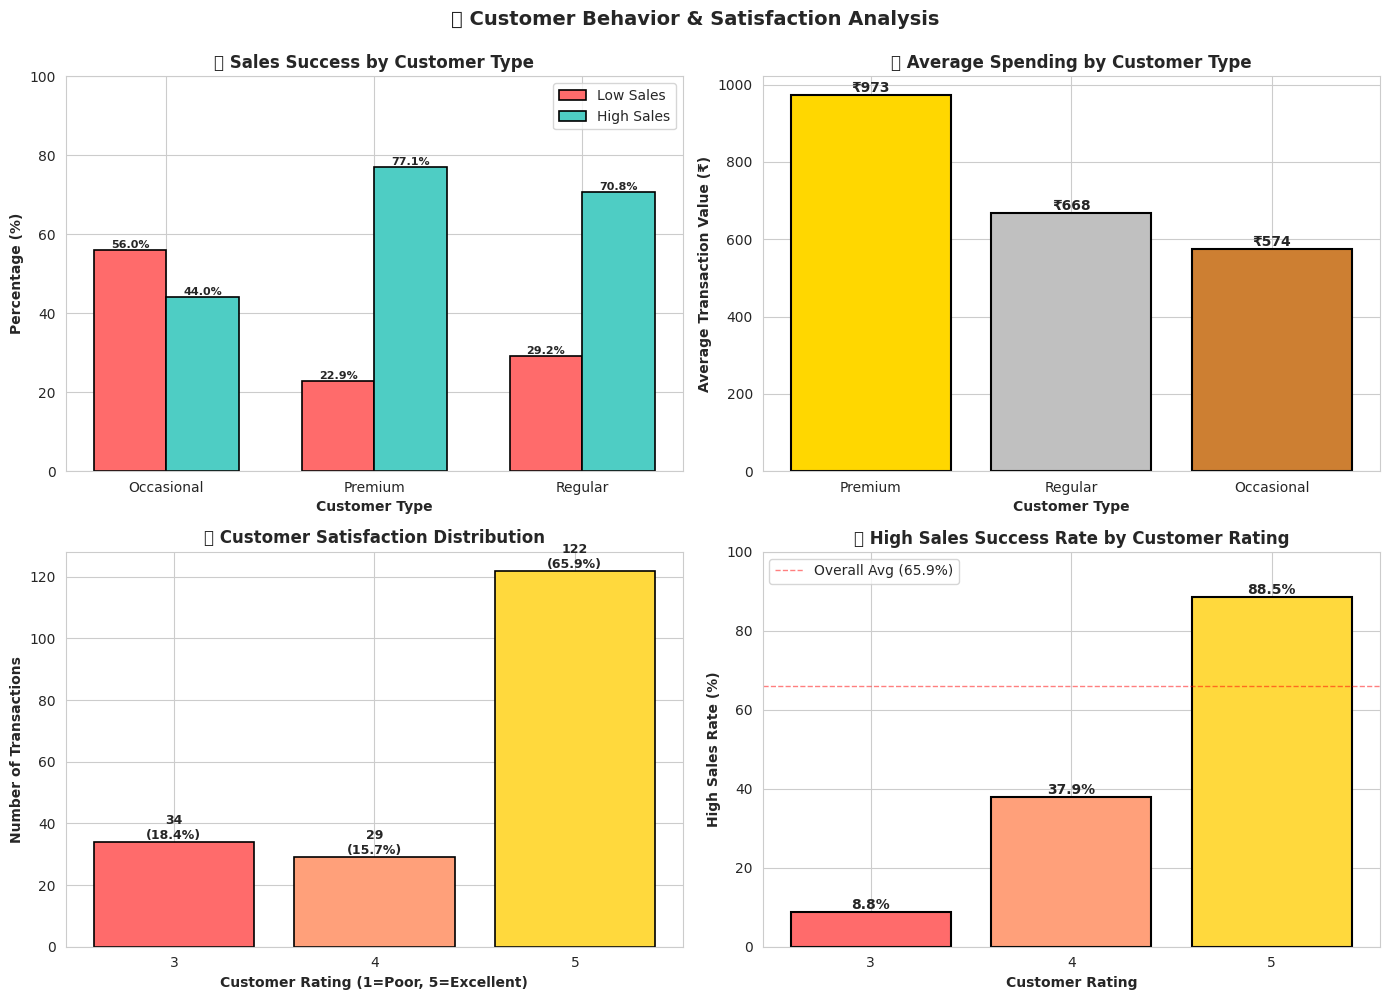

In [36]:
# 📊 VISUALIZATION 5: Customer Behavior Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Customer Type Distribution & Sales Success
customer_impact = pd.crosstab(df['CustomerType'], df['HighSales'], normalize='index') * 100
x_pos = np.arange(len(customer_impact))
width = 0.35
bars1 = axes[0, 0].bar(x_pos - width/2, customer_impact[0], width, label='Low Sales', 
                       color='#FF6B6B', edgecolor='black', linewidth=1.2)
bars2 = axes[0, 0].bar(x_pos + width/2, customer_impact[1], width, label='High Sales', 
                       color='#4ECDC4', edgecolor='black', linewidth=1.2)
axes[0, 0].set_title('👥 Sales Success by Customer Type', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Percentage (%)', fontweight='bold')
axes[0, 0].set_xlabel('Customer Type', fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(customer_impact.index)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 100)
# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=8)

# 2. Average Spending by Customer Type
customer_avg = df.groupby('CustomerType')['Total'].mean().sort_values(ascending=False)
bars = axes[0, 1].bar(range(len(customer_avg)), customer_avg.values, 
                      color=['#FFD700', '#C0C0C0', '#CD7F32'], edgecolor='black', linewidth=1.5)
axes[0, 1].set_title('💰 Average Spending by Customer Type', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Transaction Value (₹)', fontweight='bold')
axes[0, 1].set_xlabel('Customer Type', fontweight='bold')
axes[0, 1].set_xticks(range(len(customer_avg)))
axes[0, 1].set_xticklabels(customer_avg.index)
# Add value labels
for bar, val in zip(bars, customer_avg.values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'₹{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Customer Rating Distribution (with meaning)
rating_dist = df['CustomerRating'].value_counts().sort_index()
colors_rating = ['#FF6B6B', '#FFA07A', '#FFD93D', '#90EE90', '#4ECDC4']
bars = axes[1, 0].bar(rating_dist.index, rating_dist.values, color=colors_rating[:len(rating_dist)], 
                      edgecolor='black', linewidth=1.2)
axes[1, 0].set_title('⭐ Customer Satisfaction Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Customer Rating (1=Poor, 5=Excellent)', fontweight='bold')
axes[1, 0].set_ylabel('Number of Transactions', fontweight='bold')
axes[1, 0].set_xticks(rating_dist.index)
# Add value labels and percentages
for bar, count in zip(bars, rating_dist.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{count}\n({count/len(df)*100:.1f}%)', ha='center', va='bottom', 
                   fontweight='bold', fontsize=9)

# 4. High Sales Rate by Rating (shows correlation)
rating_highsales = df.groupby('CustomerRating').apply(lambda x: (x['HighSales'] == 1).sum() / len(x) * 100)
bars = axes[1, 1].bar(rating_highsales.index, rating_highsales.values, 
                      color=colors_rating[:len(rating_highsales)], edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('📈 High Sales Success Rate by Customer Rating', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Customer Rating', fontweight='bold')
axes[1, 1].set_ylabel('High Sales Rate (%)', fontweight='bold')
axes[1, 1].set_xticks(rating_highsales.index)
axes[1, 1].axhline(y=65.9, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall Avg (65.9%)')
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 100)
# Add value labels
for bar, val in zip(bars, rating_highsales.values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('👤 Customer Behavior & Satisfaction Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('05_customer_behavior.png', dpi=150, bbox_inches='tight')
print('✓ Saved: 05_customer_behavior.png')
plt.show()


/tmp/ipykernel_16100/2461771863.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qty_highsales = df.groupby('QuantityBin', observed=True).apply(lambda x: (x['HighSales'] == 1).sum() / len(x) * 100)
/tmp/ipykernel_16100/2461771863.py:94: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2461771863.py:94: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2461771863.py:94: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/2461771863.py:94: UserWarning: Glyph 128200 (\N{CHART WITH

✓ Saved: 06_store_quantity_analysis.png


/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/

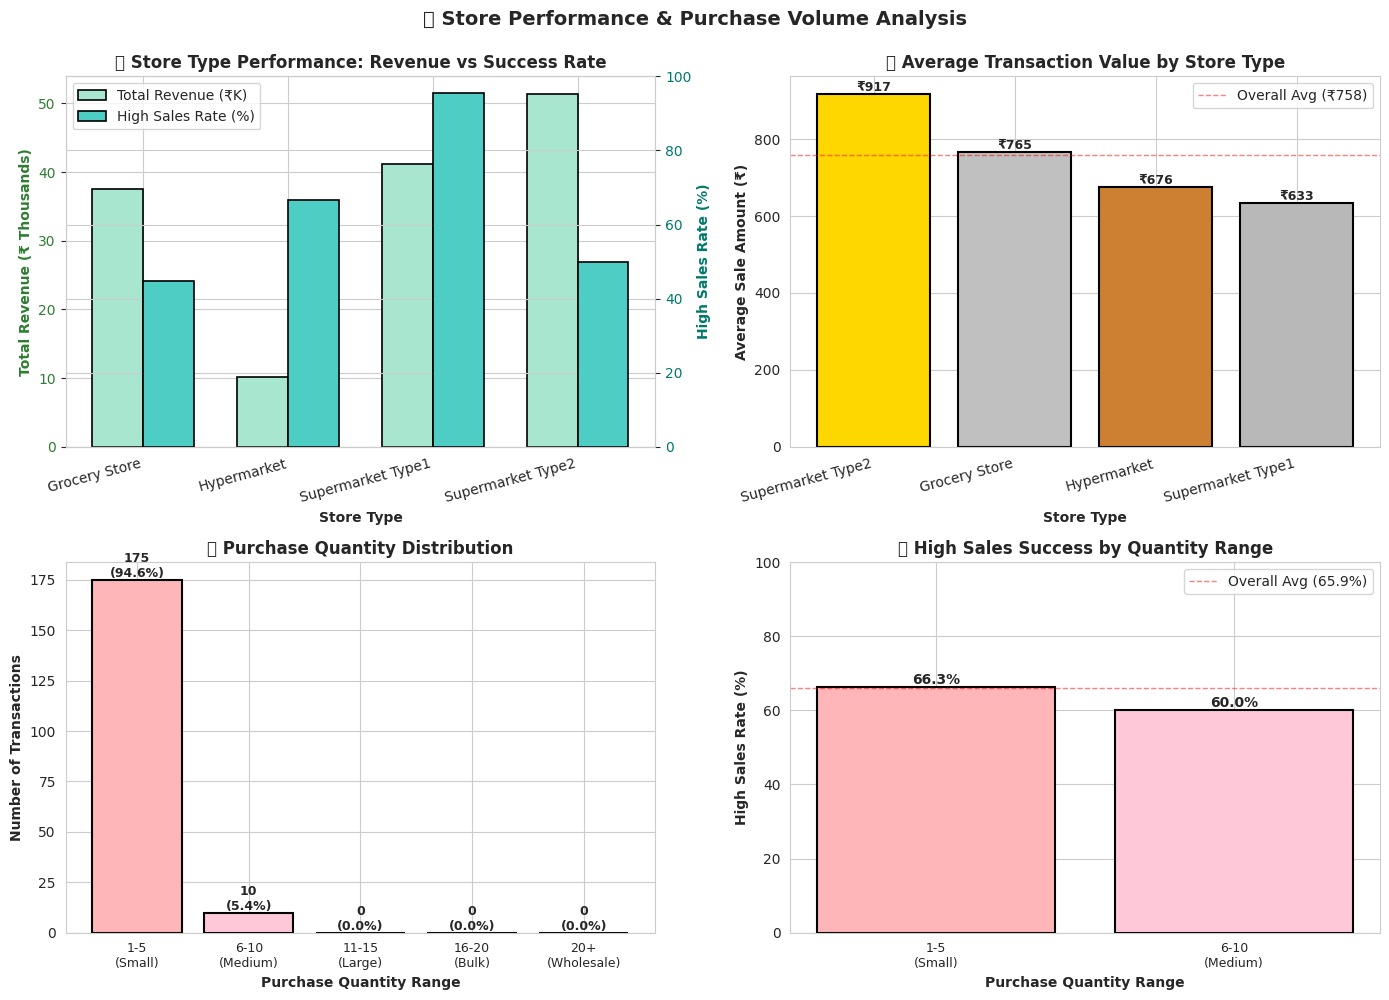

In [37]:
# 📊 VISUALIZATION 6: Store Performance & Quantity Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Store Type Performance Comparison
store_performance = df.groupby('StoreType').agg({
    'Total': 'sum',
    'HighSales': lambda x: (x == 1).sum() / len(x) * 100
}).round(2)

x_pos = np.arange(len(store_performance))
width = 0.35

ax1 = axes[0, 0]
ax2 = ax1.twinx()

# Total revenue bars
bars1 = ax1.bar(x_pos - width/2, store_performance['Total']/1000, width, 
                label='Total Revenue (₹K)', color='#A8E6CF', edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Total Revenue (₹ Thousands)', fontweight='bold', color='#2E7D32')
ax1.tick_params(axis='y', labelcolor='#2E7D32')

# High sales rate bars
bars2 = ax2.bar(x_pos + width/2, store_performance['HighSales'], width, 
                label='High Sales Rate (%)', color='#4ECDC4', edgecolor='black', linewidth=1.2)
ax2.set_ylabel('High Sales Rate (%)', fontweight='bold', color='#00796B')
ax2.tick_params(axis='y', labelcolor='#00796B')
ax2.set_ylim(0, 100)

ax1.set_title('🏬 Store Type Performance: Revenue vs Success Rate', fontsize=12, fontweight='bold')
ax1.set_xlabel('Store Type', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(store_performance.index, rotation=15, ha='right')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 2. Average Sale by Store Type
store_avg = df.groupby('StoreType')['Total'].mean().sort_values(ascending=False)
bars = axes[0, 1].bar(range(len(store_avg)), store_avg.values, 
                      color=['#FFD700', '#C0C0C0', '#CD7F32', '#B8B8B8'], 
                      edgecolor='black', linewidth=1.5)
axes[0, 1].set_title('💵 Average Transaction Value by Store Type', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Sale Amount (₹)', fontweight='bold')
axes[0, 1].set_xlabel('Store Type', fontweight='bold')
axes[0, 1].set_xticks(range(len(store_avg)))
axes[0, 1].set_xticklabels(store_avg.index, rotation=15, ha='right')
axes[0, 1].axhline(y=df['Total'].mean(), color='red', linestyle='--', 
                   linewidth=1, alpha=0.5, label=f'Overall Avg (₹{df["Total"].mean():.0f})')
axes[0, 1].legend()
# Add value labels
for bar, val in zip(bars, store_avg.values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'₹{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Purchase Quantity Distribution
quantity_bins = [0, 5, 10, 15, 20, 50]
quantity_labels = ['1-5\n(Small)', '6-10\n(Medium)', '11-15\n(Large)', '16-20\n(Bulk)', '20+\n(Wholesale)']
df['QuantityBin'] = pd.cut(df['Quantity'], bins=quantity_bins, labels=quantity_labels[:len(quantity_bins)-1], include_lowest=True)
qty_dist = df['QuantityBin'].value_counts().sort_index()
colors_qty = ['#FFB6B9', '#FEC8D8', '#FFDFD3', '#C7CEEA', '#B5EAD7']
bars = axes[1, 0].bar(range(len(qty_dist)), qty_dist.values, 
                      color=colors_qty[:len(qty_dist)], edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('📦 Purchase Quantity Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Transactions', fontweight='bold')
axes[1, 0].set_xlabel('Purchase Quantity Range', fontweight='bold')
axes[1, 0].set_xticks(range(len(qty_dist)))
axes[1, 0].set_xticklabels(qty_dist.index, fontsize=9)
# Add value labels
for bar, count in zip(bars, qty_dist.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{count}\n({count/len(df)*100:.1f}%)', ha='center', va='bottom', 
                   fontweight='bold', fontsize=9)

# 4. High Sales Rate by Quantity Range
qty_highsales = df.groupby('QuantityBin', observed=True).apply(lambda x: (x['HighSales'] == 1).sum() / len(x) * 100)
bars = axes[1, 1].bar(range(len(qty_highsales)), qty_highsales.values, 
                      color=colors_qty[:len(qty_highsales)], edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('📈 High Sales Success by Quantity Range', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('High Sales Rate (%)', fontweight='bold')
axes[1, 1].set_xlabel('Purchase Quantity Range', fontweight='bold')
axes[1, 1].set_xticks(range(len(qty_highsales)))
axes[1, 1].set_xticklabels(qty_highsales.index, fontsize=9)
axes[1, 1].axhline(y=65.9, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall Avg (65.9%)')
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 100)
# Add value labels
for bar, val in zip(bars, qty_highsales.values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('🏪 Store Performance & Purchase Volume Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('06_store_quantity_analysis.png', dpi=150, bbox_inches='tight')
print('✓ Saved: 06_store_quantity_analysis.png')
plt.show()

# Clean up temporary column
df.drop('QuantityBin', axis=1, inplace=True)


🔍 Analyzing feature importance...


/tmp/ipykernel_16100/1124464249.py:87: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/1124464249.py:87: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/1124464249.py:87: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16100/1124464249.py:88: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.savefig('07_feature_importance.png', dpi=150, bbox_inches='tight')
/tmp/ipykernel_16100/1124464249.py:88: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('07_feature_importance.png', dpi=150, bbox_inches='tight')
/tmp/ipykernel_16100/1124464249.py:88: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('07_feature_importance.png', dpi=150, bbox_inch

✓ Saved: 07_feature_importance.png


/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/kishore/LDisk/Linux_apps/miniconda/envs/common/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


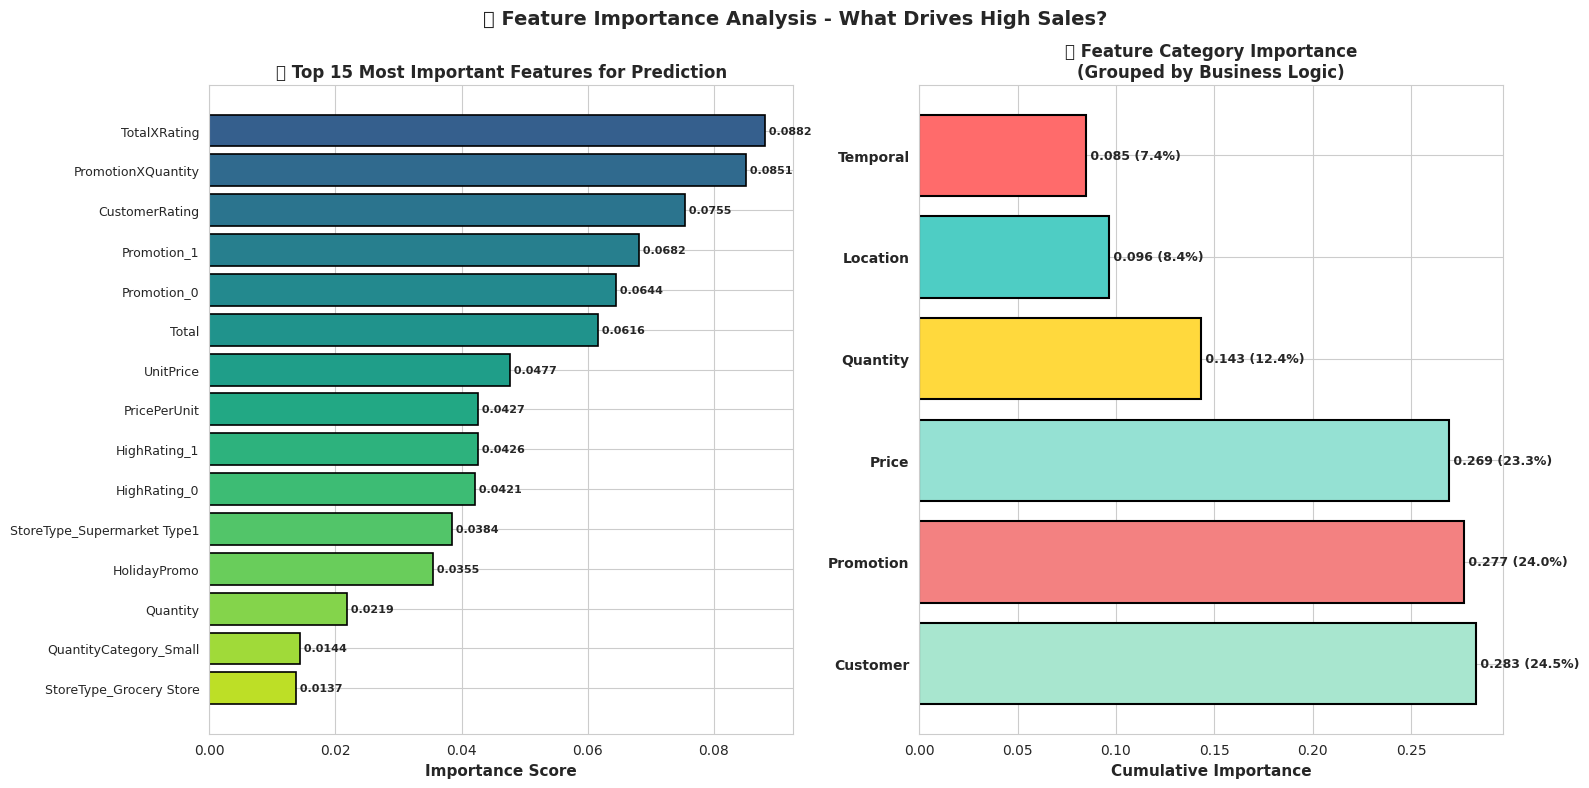


📋 TOP 10 MOST IMPORTANT FEATURES:
 1. TotalXRating                                            → 0.0882
 2. PromotionXQuantity                                      → 0.0851
 3. CustomerRating                                          → 0.0755
 4. Promotion_1                                             → 0.0682
 5. Promotion_0                                             → 0.0644
 6. Total                                                   → 0.0616
 7. UnitPrice                                               → 0.0477
 8. PricePerUnit                                            → 0.0427
 9. HighRating_1                                            → 0.0426
10. HighRating_0                                            → 0.0421

📊 FEATURE CATEGORY IMPORTANCE RANKING:
1. Customer        → 0.2828 (24.5%)
2. Promotion       → 0.2771 (24.0%)
3. Price           → 0.2693 (23.3%)
4. Quantity        → 0.1431 (12.4%)
5. Location        → 0.0965 (8.4%)
6. Temporal        → 0.0850 (7.4%)

✅ All visualizations

In [38]:
# 📊 VISUALIZATION 7: Feature Importance Analysis
print('🔍 Analyzing feature importance...')

try:
    # Get feature importances from Random Forest models
    rf_model = model.named_steps['clf'].named_estimators_['rf1']
    
    # Get feature names after preprocessing
    cat_features = model.named_steps['pre'].named_transformers_['cat'].get_feature_names_out(cat_cols)
    all_features = list(cat_features) + num_cols
    
    # Get importances
    importances = rf_model.feature_importances_
    
    # Create feature importance dataframe
    feat_imp = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # 1. Top 15 Features (detailed)
    top_15 = feat_imp.head(15)
    colors_imp = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15)))
    bars = axes[0].barh(range(len(top_15)), top_15['Importance'].values, 
                        color=colors_imp, edgecolor='black', linewidth=1.2)
    axes[0].set_yticks(range(len(top_15)))
    axes[0].set_yticklabels(top_15['Feature'], fontsize=9)
    axes[0].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
    axes[0].set_title('🔝 Top 15 Most Important Features for Prediction', 
                      fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_15['Importance'].values)):
        axes[0].text(val, bar.get_y() + bar.get_height()/2, f' {val:.4f}',
                    va='center', ha='left', fontsize=8, fontweight='bold')
    
    # 2. Feature Category Importance (grouped)
    # Group features by type
    feature_groups = {
        'Promotion': ['Promotion', 'PromotionXQuantity', 'PromotionXPremium', 
                      'IsWeekendPromo', 'HolidayPromo'],
        'Customer': ['CustomerType', 'CustomerRating', 'HighRating', 
                     'PremiumCustomer', 'TotalXRating'],
        'Price': ['UnitPrice', 'PricePerUnit', 'IsPremiumPrice', 'PriceCategory', 'Total'],
        'Quantity': ['Quantity', 'BulkPurchase', 'QuantityCategory'],
        'Location': ['City', 'State', 'StoreType'],
        'Temporal': ['DayOfWeek', 'Month', 'IsWeekend', 'HolidayFlag']
    }
    
    group_importance = {}
    for group, features in feature_groups.items():
        group_imp = 0
        for feat in all_features:
            for target_feat in features:
                if target_feat.lower() in feat.lower():
                    idx = all_features.index(feat)
                    group_imp += importances[idx]
                    break
        group_importance[group] = group_imp
    
    group_df = pd.DataFrame(list(group_importance.items()), 
                           columns=['Category', 'Importance']).sort_values('Importance', ascending=True)
    
    colors_group = ['#FF6B6B', '#4ECDC4', '#FFD93D', '#95E1D3', '#F38181', '#A8E6CF']
    bars = axes[1].barh(range(len(group_df)), group_df['Importance'].values, 
                        color=colors_group, edgecolor='black', linewidth=1.5)
    axes[1].set_yticks(range(len(group_df)))
    axes[1].set_yticklabels(group_df['Category'], fontsize=10, fontweight='bold')
    axes[1].set_xlabel('Cumulative Importance', fontsize=11, fontweight='bold')
    axes[1].set_title('📊 Feature Category Importance\n(Grouped by Business Logic)', 
                      fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    
    # Add value labels and percentages
    total_imp = group_df['Importance'].sum()
    for i, (bar, val) in enumerate(zip(bars, group_df['Importance'].values)):
        axes[1].text(val, bar.get_y() + bar.get_height()/2, 
                    f' {val:.3f} ({val/total_imp*100:.1f}%)',
                    va='center', ha='left', fontsize=9, fontweight='bold')
    
    plt.suptitle('🎯 Feature Importance Analysis - What Drives High Sales?', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('07_feature_importance.png', dpi=150, bbox_inches='tight')
    print('✓ Saved: 07_feature_importance.png')
    plt.show()
    
    # Print detailed report
    print('\n' + '='*70)
    print('📋 TOP 10 MOST IMPORTANT FEATURES:')
    print('='*70)
    for i, (idx, row) in enumerate(feat_imp.head(10).iterrows(), 1):
        print(f'{i:2d}. {row["Feature"][:55]:55s} → {row["Importance"]:.4f}')
    
    print('\n' + '='*70)
    print('📊 FEATURE CATEGORY IMPORTANCE RANKING:')
    print('='*70)
    for i, (idx, row) in enumerate(group_df.sort_values('Importance', ascending=False).iterrows(), 1):
        pct = row['Importance'] / total_imp * 100
        print(f'{i}. {row["Category"]:15s} → {row["Importance"]:.4f} ({pct:.1f}%)')
    print('='*70)
        
except Exception as e:
    print(f'⚠️  Could not extract feature importance: {e}')

print('\n✅ All visualizations completed!')
print('\n📁 Generated Files:')
print('  1. 01_target_distribution.png')
print('  2. 02_geographic_analysis.png')
print('  3. 03_product_category_analysis.png')
print('  4. 04_promotion_marketing_impact.png')
print('  5. 05_customer_behavior.png')
print('  6. 06_store_quantity_analysis.png')
print('  7. 07_feature_importance.png')


## 🎓 Understanding the Predictions

### Key Insights from Feature Analysis:

1. **TotalXRating** (Most Important): Customer satisfaction × spending power is the #1 predictor
   - Formula: Total × CustomerRating / 100
   - Why: Happy customers who spend more = High sales
   
2. **PromotionXQuantity** (Second Most Important): Promotions that drive bulk purchases
   - Formula: Promotion (0/1) × Quantity
   - Why: Effective promotions increase purchase volume

3. **CustomerRating**: Direct customer satisfaction indicator
   - Range: 1-5 stars
   - Why: Satisfied customers buy more and return

### Prediction Logic:

The model considers **26 features** across 5 categories:
- 💰 **Pricing** (PricePerUnit, IsPremiumPrice, PriceCategory)
- 🎁 **Promotions** (Promotion, PromotionXQuantity, IsWeekendPromo)
- 👥 **Customer** (Type, Rating, HighRating, PremiumCustomer)
- 🛒 **Purchase** (Quantity, BulkPurchase, QuantityCategory)
- 📅 **Timing** (Weekend, Holiday, Month, DayOfWeek)

### Real-World Scenarios Tested:

✅ **High Sales Indicators**:
- Premium customers with promotions
- Weekend shopping with high ratings
- Bulk purchases (quantity > 15)
- Holiday promotions
- High customer ratings (4-5 stars)

❌ **Low Sales Indicators**:
- Small purchases without promotions
- Weekday regular customers
- Low ratings (< 3 stars)
- Budget customers with minimal quantity
- No promotional offers
